# Importing Lines

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from glob import glob
from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Hyperparams

In [2]:
SEED = 43

# Read-in Data

In [3]:
PATH = '../res/npy_img/left/'
files = glob(PATH+'*.npy')

In [4]:
sample = torch.tensor(np.load(files[0]))
x, y, f = np.load(files[0]).shape

In [5]:
def data_loader(files):
    out = []
    x, y, f = np.load(files[0]).shape
    for file in tqdm(files):
        file = np.load(file)
        out.append(file.transpose(2, 0, 1))
    out = np.array(out)
    return torch.tensor(out, dtype=torch.float)

In [6]:
np.load(files[0]).shape

(307, 375, 6)

In [7]:
X = data_loader(files)

In [8]:
label = pd.read_csv('../res/age_balanced.csv', index_col=0)
y_multi = torch.tensor(label.multiclass.values)
y_binary = torch.tensor(label.binary.values)

In [9]:
# Binary
X_train, X_test, y_binary_train, y_binary_test = train_test_split(X, y_binary,
                                                                  test_size=0.2, random_state=SEED)
train_binary_ds = TensorDataset(X_train, y_binary_train)
test_binary_ds = TensorDataset(X_test, y_binary_test)
train_binary_loader = DataLoader(train_binary_ds, batch_size=64, shuffle=True)
test_binary_loader = DataLoader(test_binary_ds, batch_size=64, shuffle=True)

sample_multi_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_multi_loader = DataLoader(sample_multi_ds)

In [10]:
# Binary
X_train, X_test, y_multi_train, y_multi_test = train_test_split(X, y_multi,
                                                                test_size=0.2, random_state=SEED)
train_multi_ds = TensorDataset(X_train, y_multi_train)
test_multi_ds = TensorDataset(X_test, y_multi_test)
train_multi_loader = DataLoader(train_multi_ds, batch_size=128, shuffle=True)
test_multi_loader = DataLoader(test_multi_ds, batch_size=128, shuffle=True)

sample_binary_ds = TensorDataset(X_train[2:4], y_binary_train[2:4])
sample_binary_loader = DataLoader(sample_binary_ds)

# Functions in Need

In [11]:
def count(y_pred, y_true):
    y_pred_ = y_pred.argmax(axis=1)
    
    corr = 0
    for p, t in zip(y_pred_, y_true):
        if p == t:
            corr += 1
            
    return corr

# Model Implementation

## Model

In [33]:
class ConvNet(nn.Module):
    def __init__(self, ctype):
        super(ConvNet, self).__init__()
        
        self.ctype = ctype
        if self.ctype=='binary':
            out_node = 1
            self.last_layer = F.sigmoid
        elif self.ctype=='multi':
            out_node = 10
            self.last_layer = F.softmax
        else:
            print("Put either 'binary' or 'multi'")
        
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(6, 10, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(20, 40, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(480, 100)
        self.fc2 = nn.Linear(100, out_node)

        
    def forward(self, x):
        out = self.layer1(x)
#         out = self.drop_out(out)
        out = self.layer2(out)
#         out = self.drop_out(out)
        out = self.layer3(out)
#         out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        out = self.last_layer(out)
        return out

## Functions need in Future

In [13]:
def acc_multi(pred, true):
    result = 0
    cnt = 0
    for p, t in zip(pred.argmax(axis=1), true):
        cnt += 1
        if p == t:
            result += 1
            
    return result, cnt

In [14]:
def acc_binary(pred, true):
    correct, cnt = 0, 0
    tp, tn, fp, fn = 0, 0, 0, 0
    for p, t in zip(pred, true):
        cnt += 1
        if (p >= 0.5) & (t == 1):
            correct += 1
            tp += 1
            
        elif (p >= 0.5) & (t == 0):
            fp += 1
            
        elif (p < 0.5) & (t == 1):
            tn += 1
            
        elif (p < 0.5) & (t == 0):
            correct += 1
            fn += 1
        
        else:
            pass
        
    return correct, cnt, np.array([tp, tn, fp, fn])

In [15]:
def to_binary(data):
    result = []
    for d in data:
        if d >= 0.5:
            result.append(1)
        elif d < 0.5:
            result.append(0)
    return result

## Debugging

In [16]:
conv = ConvNet(ctype='binary')
for x, y in sample_binary_loader:
    print(conv(x))

tensor([[0.4911]], grad_fn=<SigmoidBackward>)
tensor([[0.4592]], grad_fn=<SigmoidBackward>)


C:\Users\pha\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [34]:
conv = ConvNet(ctype='multi')
for x, y in train_multi_loader:
    print(conv(x).argmax(axis=1))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([5, 7, 5, 5, 7, 5, 7, 5, 5, 7, 3, 5, 8, 5, 7, 5, 5, 5, 5, 7, 7, 7, 5, 7,
        3, 7, 5, 5, 5, 5, 7, 7, 7, 5, 7, 7, 5, 5, 5, 8, 5, 7, 8, 5, 5, 7, 5, 7,
        7, 5, 7, 5, 7, 1, 1, 7, 5, 7, 5, 8, 7, 7, 1, 7, 7, 5, 5, 7, 5, 7, 7, 7,
        5, 7, 5, 5, 5, 5, 5, 8, 7, 5, 7, 5, 7, 5, 5, 7, 5, 5, 5, 7, 7, 8, 5, 5,
        7, 7, 7, 7, 5, 5, 5, 7, 7, 1, 8, 7, 7, 7, 7, 5, 7, 7, 5, 5, 7, 5, 7, 7,
        7, 7, 5, 3, 5, 5, 5, 5], grad_fn=<NotImplemented>)
tensor([7, 7, 7, 5, 5, 7, 5, 7, 5, 5, 7, 5, 1, 1, 7, 7, 7, 7, 8, 5, 8, 5, 7, 7,
        7, 5, 5, 7, 5, 5, 5, 5, 7, 5, 8, 7, 1, 5, 5, 7, 5, 8, 7, 5, 7, 8, 8, 5,
        5, 7, 5, 5, 7, 8, 5, 7, 7, 5, 1, 5, 1, 7, 7, 5, 5, 7, 7, 7, 5, 7, 8, 5,
        5, 5, 5, 5, 7, 8, 8, 7, 8, 5, 5, 5, 7, 5, 7, 5, 5, 5, 5, 5, 5, 7, 5, 7,
        8, 7, 7, 5, 5, 7, 5, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 5, 7, 7, 7, 7, 7, 5,
        1, 5, 7, 7, 8, 8, 7, 7], grad_fn=<NotImplemented>)
tensor([7, 5, 7, 5, 7, 5, 7, 5, 5, 7, 5, 7, 7, 7, 7, 5, 7, 7, 5, 5, 5, 1, 7, 7,
  

## Weighting

In [19]:
multi_weight = sorted(Counter(label.multiclass).items(), key=(lambda x: x[0]))
multi_weight = 1 / np.array([w[1] for w in multi_weight])

In [20]:
binary_weight = sorted(Counter(label.binary).items(), key=(lambda x: x[0]))
binary_weight = 1 / np.array([w[1] for w in binary_weight])

## Training - Multiclass

In [35]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='multi')

EPOCHS = range(200)
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(multi_weight))
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_multi_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t = acc_multi(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_multi_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t = acc_multi(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        #print("Prediction: {}".format(y_pred.argmax(axis=1)))
        #print("Prediction: {}".format(y_pred[:3]))
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


EPOCH: 0
[LOSS] train: 14.052, val: 4.678
[ACC%] train: 10.68%, val: 9.77%
EPOCH: 1
[LOSS] train: 13.963, val: 4.605
[ACC%] train: 9.67%, val: 6.32%
EPOCH: 2
[LOSS] train: 13.814, val: 4.606
[ACC%] train: 8.08%, val: 8.62%
EPOCH: 3
[LOSS] train: 13.819, val: 4.61
[ACC%] train: 8.37%, val: 8.62%
EPOCH: 4
[LOSS] train: 13.812, val: 4.609
[ACC%] train: 8.23%, val: 9.2%
EPOCH: 5
[LOSS] train: 13.818, val: 4.609
[ACC%] train: 13.28%, val: 9.2%
EPOCH: 6
[LOSS] train: 13.815, val: 4.609
[ACC%] train: 13.28%, val: 9.2%
EPOCH: 7
[LOSS] train: 13.813, val: 4.61
[ACC%] train: 12.84%, val: 9.2%
EPOCH: 8
[LOSS] train: 13.811, val: 4.612
[ACC%] train: 13.56%, val: 9.2%
EPOCH: 9
[LOSS] train: 13.817, val: 4.613
[ACC%] train: 13.28%, val: 9.2%
EPOCH: 10
[LOSS] train: 13.811, val: 4.61
[ACC%] train: 13.28%, val: 9.2%
EPOCH: 11
[LOSS] train: 13.814, val: 4.609
[ACC%] train: 10.25%, val: 7.47%
EPOCH: 12
[LOSS] train: 13.813, val: 4.609
[ACC%] train: 10.39%, val: 8.05%
EPOCH: 13
[LOSS] train: 13.814, val:

EPOCH: 109
[LOSS] train: 12.829, val: 4.708
[ACC%] train: 32.32%, val: 6.9%
EPOCH: 110
[LOSS] train: 12.743, val: 4.672
[ACC%] train: 32.76%, val: 6.9%
EPOCH: 111
[LOSS] train: 12.723, val: 4.699
[ACC%] train: 32.32%, val: 7.47%
EPOCH: 112
[LOSS] train: 12.777, val: 4.711
[ACC%] train: 30.45%, val: 7.47%
EPOCH: 113
[LOSS] train: 12.981, val: 4.659
[ACC%] train: 29.15%, val: 8.05%
EPOCH: 114
[LOSS] train: 12.993, val: 4.66
[ACC%] train: 28.14%, val: 9.77%
EPOCH: 115
[LOSS] train: 12.778, val: 4.711
[ACC%] train: 32.47%, val: 6.32%
EPOCH: 116
[LOSS] train: 12.975, val: 4.738
[ACC%] train: 30.01%, val: 4.6%
EPOCH: 117
[LOSS] train: 12.824, val: 4.691
[ACC%] train: 32.47%, val: 5.75%
EPOCH: 118
[LOSS] train: 12.813, val: 4.678
[ACC%] train: 31.6%, val: 8.05%
EPOCH: 119
[LOSS] train: 12.916, val: 4.704
[ACC%] train: 30.74%, val: 6.32%
EPOCH: 120
[LOSS] train: 12.789, val: 4.692
[ACC%] train: 33.04%, val: 7.47%
EPOCH: 121
[LOSS] train: 12.755, val: 4.713
[ACC%] train: 33.77%, val: 5.75%
EPOC

In [22]:
for x, y in test_multi_loader:
    print(y)

tensor([8, 7, 6, 9, 2, 9, 9, 1, 0, 4, 0, 7, 6, 3, 3, 8, 8, 8, 9, 1, 7, 0, 7, 0,
        3, 1, 3, 1, 0, 5, 5, 9, 6, 2, 8, 1, 0, 2, 7, 8, 7, 8, 4, 3, 1, 4, 0, 3,
        5, 6, 8, 4, 7, 8, 1, 7, 5, 0, 9, 6, 2, 1, 1, 2, 3, 7, 4, 9, 1, 7, 4, 3,
        3, 7, 6, 6, 7, 9, 9, 8, 6, 1, 4, 5, 5, 6, 2, 1, 1, 6, 4, 9, 1, 3, 9, 5,
        5, 9, 7, 1, 3, 7, 2, 8, 8, 0, 8, 6, 0, 2, 2, 2, 5, 5, 9, 5, 4, 2, 0, 4,
        1, 8, 6, 0, 1, 0, 0, 4])
tensor([0, 2, 5, 2, 7, 0, 8, 0, 7, 0, 2, 3, 8, 4, 3, 5, 2, 6, 3, 6, 0, 9, 8, 8,
        2, 4, 6, 5, 8, 8, 8, 2, 4, 3, 4, 8, 8, 5, 0, 3, 0, 1, 7, 3, 6, 7])


[]

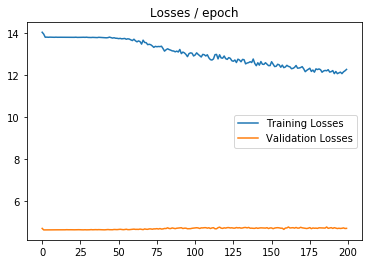

In [36]:
plt.title("Losses / epoch")
plt.plot(train_losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.legend()
plt.plot()

[]

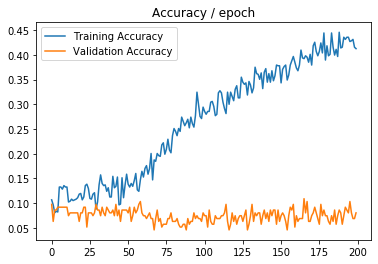

In [37]:
plt.title("Accuracy / epoch")
plt.plot(np.array(train_accs)/train_cnt, label='Training Accuracy')
plt.plot(np.array(val_accs)/val_cnt, label='Validation Accuracy')
plt.legend()
plt.plot()

In [55]:
conv(x).argmax(axis=1)

C:\Users\pha\anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([2, 6, 1, 6, 7, 5, 0, 2, 6, 5, 2, 0, 8, 7, 8, 7, 6, 3, 8, 8, 3, 7, 5, 8,
        4, 6, 2, 8, 3, 3, 3, 1, 8, 3, 1, 1, 2, 1, 4, 3, 1, 6, 2, 9, 0, 1],
       grad_fn=<NotImplemented>)

In [1]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

conv = ConvNet(ctype='binary')

EPOCHS = range(100)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(conv.parameters(), lr=.001)

for epoch in EPOCHS:
    
    train_batch_loss, train_batch_acc, train_cnt = 0, 0, 0
    conv.train()
    for x, y in train_binary_loader:
        
        optimizer.zero_grad()
        y_pred = conv(x)
        
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        #print("Prediction: {}".format(conv(x).argmax(axis=1)))
        #print("True Value: {}".format(y))
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        train_batch_acc += tmp_acc
        train_cnt += tmp_t
        
        train_batch_loss += loss.item()
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    
    val_batch_loss, val_batch_acc, val_cnt = 0, 0, 0
    conv.eval()
    for x, y in test_binary_loader:
        y_pred = conv(x)
        loss = loss_fn(y_pred, y)
        
        tmp_acc, tmp_t, tmp_cf = acc_binary(y_pred, y)
        val_batch_acc += tmp_acc
        val_cnt += tmp_t
        
        val_batch_loss += loss.item()
        
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)
    
    print("EPOCH: {}".format(epoch))
    print("[LOSS] train: {}, val: {}".format(round(train_batch_loss,3), round(val_batch_loss, 3)))
    print("[ACC%] train: {}%, val: {}%"
          .format(round(train_batch_acc/train_cnt * 100, 2), round(val_batch_acc/val_cnt * 100, 2)))
    #print("Prediction: {}".format(conv(xx).argmax(axis=1)))
    #print("True Value: {}".format(yy))

NameError: name 'ConvNet' is not defined

In [72]:
pred = torch.tensor([0.1, 0.2, 0.3, 0.9], dtype=torch.float)
true = torch.tensor([0, 0, 0, 1], dtype=torch.float)
loss_fn(pred, true)

tensor(0.1976)